# Imports

In [9]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from utils.loading_utils import get_pretrained_model

# Constants

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_K = 100        # Top k activations to look at
DATA_DIR = "./experimental_data/"
torch.set_grad_enabled(False)

print(f"Executing on device {device}")

Executing on device cuda


# Load data

In [11]:
diffs_resid = torch.load(DATA_DIR + "diffs_resid.pt")
acts_resid = torch.load(DATA_DIR + "acts_resid.pt")
acts_exp_resid = torch.load(DATA_DIR + "acts_exp_resid.pt")

/tmp/slurm/3107429/ipykernel_131070/197183558.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffs_resid = torch.load(DATA_DIR + "diffs_resid.pt")
/tmp/slurm/3107429/ip

# Mean and std

In [12]:
mean_diffs_resid = torch.mean(diffs_resid, dim=0)
std_diffs_resid = torch.std(diffs_resid, dim=0)
mean_exp_resid = torch.mean(acts_exp_resid, dim=0)
std_exp_resid = torch.std(acts_exp_resid, dim=0)
mean_resid = torch.mean(acts_resid, dim=0)
std_resid = torch.std(acts_resid, dim=0)

print them

In [13]:
def print_mean_std(array: torch.Tensor):
    """
    Prints the mean and standard deviation of the array.
    args:
        array: The array to print the mean and standard deviation of.
    """
    for i in range(array.shape[0]):
        print(f"Layer {i}")
        # print(f"mean: {mean_diffs_resid[i]}")
        # print(f"std: {std_diffs_resid[i]}")
        print(f"mean std: {torch.mean(array[i])}")

print_mean_std(std_exp_resid)
print_mean_std(std_resid)

Layer 0
mean std: 0.1465611457824707
Layer 1
mean std: 0.20148704946041107
Layer 2
mean std: 0.21144188940525055
Layer 3
mean std: 0.2183949202299118
Layer 4
mean std: 0.2396685779094696
Layer 5
mean std: 0.2824363708496094
Layer 6
mean std: 0.30160418152809143
Layer 7
mean std: 0.3760932385921478
Layer 8
mean std: 0.4313185513019562
Layer 9
mean std: 0.5102485418319702
Layer 10
mean std: 0.5457360744476318
Layer 11
mean std: 0.6641917824745178
Layer 12
mean std: 0.6880410313606262
Layer 13
mean std: 0.7409491539001465
Layer 14
mean std: 0.7623183131217957
Layer 15
mean std: 0.7699615955352783
Layer 16
mean std: 0.9115833640098572
Layer 17
mean std: 0.888322651386261
Layer 18
mean std: 0.9599918723106384
Layer 19
mean std: 1.0354782342910767
Layer 20
mean std: 1.082692265510559
Layer 21
mean std: 1.240518569946289
Layer 22
mean std: 1.4347070455551147
Layer 23
mean std: 1.5840013027191162
Layer 24
mean std: 1.8726294040679932
Layer 25
mean std: 2.7420248985290527
Layer 0
mean std: 0.42

# Find CoT related activations by averaging out irrelevant features

In [14]:
def get_min_std_indeces(std_resid: torch.Tensor, k: int):
    """
    Gets the indices of the minimum standard deviation for each layer.
    args:
        std_resid: The standard deviation of the activations.
        k: Top k minimum standard deviations to return.
    returns:
        The indices of the minimum standard deviation for each layer.
    """
    indeces = []
    for i in range(std_resid.shape[0]):
        indeces_layer_i = torch.argsort(std_resid[i, :], dim=0, descending=False)[:k]
        indeces.append(indeces_layer_i)
    indeces = torch.stack(indeces)
    return indeces

cot_diffs_indeces = get_min_std_indeces(std_diffs_resid, TOP_K)
cot_exp_indeces = get_min_std_indeces(std_exp_resid, TOP_K)
cot_indeces = get_min_std_indeces(std_resid, TOP_K)

# Visualization

### std

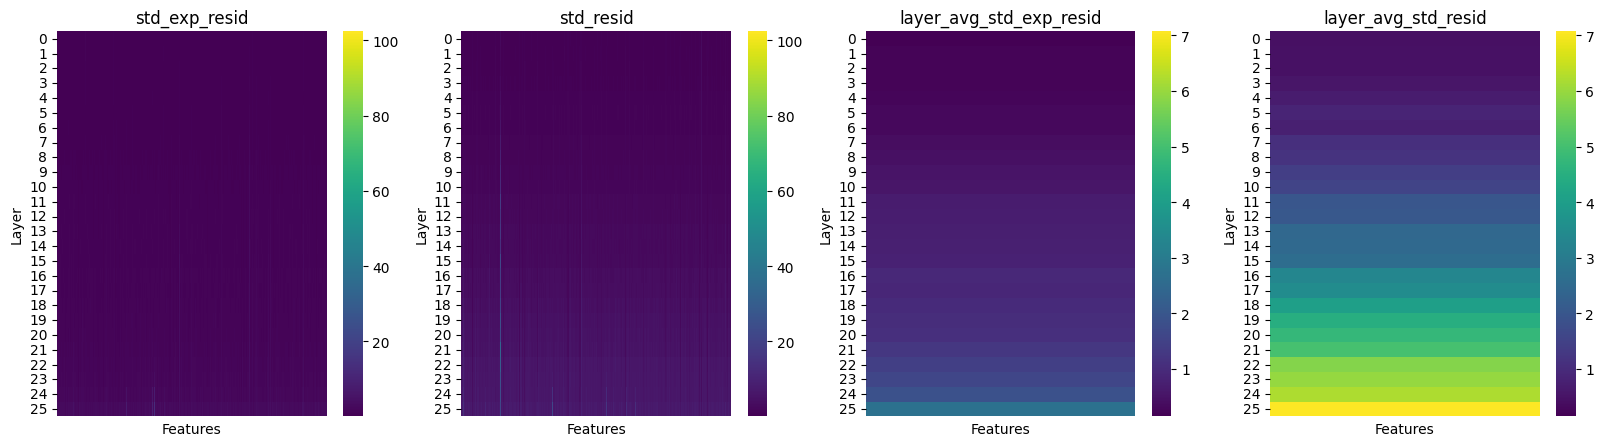

In [15]:
def draw_heatmap(tensor: torch.Tensor, title: str, axis=None, vmin=None, vmax=None):
    """
    Draws a heatmap of the tensor.
    args:
        tensor: The tensor to draw the heatmap of. Must have dimensionality of 2
        title: The title of the heatmap.
        axis: The axis to draw the heatmap on (for side-by-side plots), default to None if not needed
        vmin: The minimum value to draw on heatmap, defaults to None
        vmax: The maximum value to draw on heatmap, defaults to None
    """
    data = tensor.to(torch.float32).cpu().numpy()
    sns.heatmap(data, cmap='viridis', cbar=True, xticklabels=False, yticklabels=True, ax=axis, vmin=vmin, vmax=vmax)

    ax = axis if axis is not None else plt.gca()
    ax.set_xlabel('Features')
    ax.set_ylabel('Layer')
    ax.set_title(title)

layer_avg_std_exp_resid = torch.mean(std_exp_resid, dim=1).unsqueeze(1)
layer_avg_std_resid = torch.mean(std_resid, dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
vmin = torch.min(torch.min(std_exp_resid), torch.min(std_resid))
vmax = torch.max(torch.max(std_exp_resid), torch.max(std_resid))
draw_heatmap(std_exp_resid, "std_exp_resid", axes[0], vmin=vmin, vmax=vmax)
draw_heatmap(std_resid, "std_resid", axes[1], vmin=vmin, vmax=vmax)
vmin = torch.min(torch.min(layer_avg_std_exp_resid), torch.min(layer_avg_std_resid))
vmax = torch.max(torch.max(layer_avg_std_exp_resid), torch.max(layer_avg_std_resid))
draw_heatmap(layer_avg_std_exp_resid, "layer_avg_std_exp_resid", axes[2], vmin=vmin, vmax=vmax)
draw_heatmap(layer_avg_std_resid, "layer_avg_std_resid", axes[3], vmin=vmin, vmax=vmax)
plt.show()

It seems like the middle layers have higher std for non-CoT. We can also notice a feature with very high std at the last layer for CoT. Looking at the mean of std at each layer, it seems like our claim can be verified. It is possible that non-CoT started retrieving knowledge in earlier layers, maybe CoT neuron lies in the earlier layers such that non-CoT is not signaled with CoT and therefore started retrieving knowledge earlier. This is consistent with our findings on llama-3.2-1b:
![](./figs/llama-3.2-1b-std_resid_comp.png)

### mean

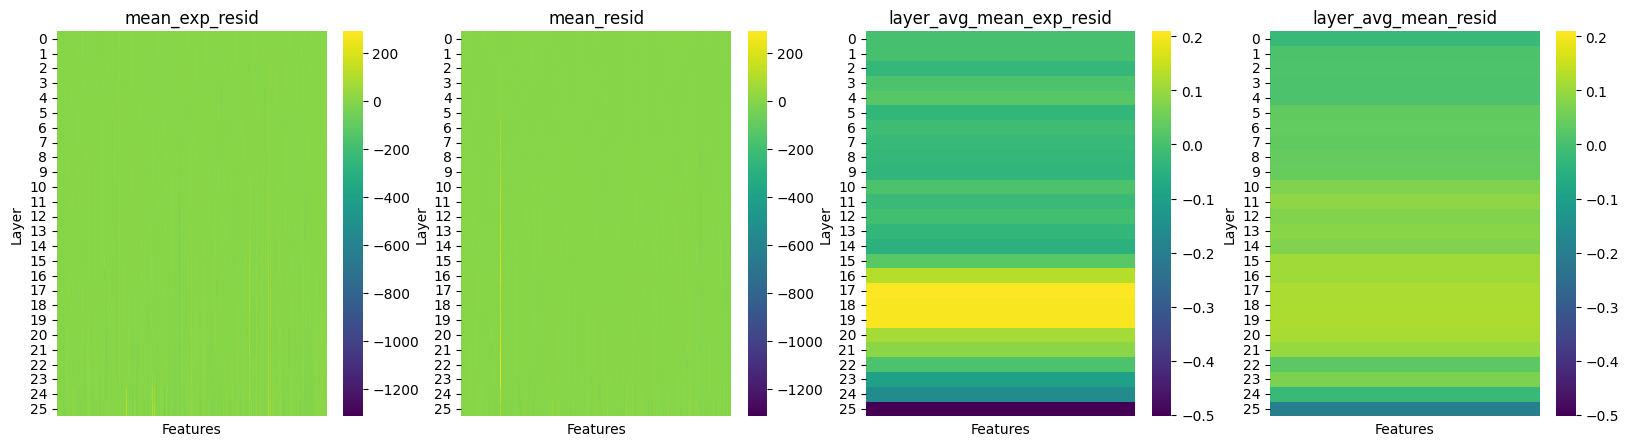

In [16]:
layer_avg_mean_exp_resid = torch.mean(mean_exp_resid, dim=1).unsqueeze(1)
layer_avg_mean_resid = torch.mean(mean_resid, dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
vmin = torch.min(torch.min(mean_exp_resid), torch.min(mean_resid))
vmax = torch.max(torch.max(mean_exp_resid), torch.max(mean_resid))
draw_heatmap(mean_exp_resid, "mean_exp_resid", axes[0], vmin=vmin, vmax=vmax)
draw_heatmap(mean_resid, "mean_resid", axes[1], vmin=vmin, vmax=vmax)
vmin = torch.min(torch.min(layer_avg_mean_exp_resid), torch.min(layer_avg_mean_resid))
vmax = torch.max(torch.max(layer_avg_mean_exp_resid), torch.max(layer_avg_mean_resid))
draw_heatmap(layer_avg_mean_exp_resid, "layer_avg_mean_exp_resid", axes[2], vmin=vmin, vmax=vmax)
draw_heatmap(layer_avg_mean_resid, "layer_avg_mean_resid", axes[3], vmin=vmin, vmax=vmax)
plt.show()

Means of Non-CoT gets smaller per layer, while Non-CoT jumps back-and-forth across different layers. It is worth noticing that Non-CoT gets much smaller compared to CoT down the layers. This could be due to retierval of knowledge in early layers that guided misinformation which propagated down the pipeline, whereas CoT does not attempt to retrieve all the information at once. Activations from gemma-2-2b-it is slightly different from our observations on llama-3.2-1b. However, gemma-2-2b-it also have a concentrated high-mean area around its mid to later layers Below are results from llama-3.2-1b
![](./figs/llama-3.2-1b-mean_resid_comp.png)

### Diffs

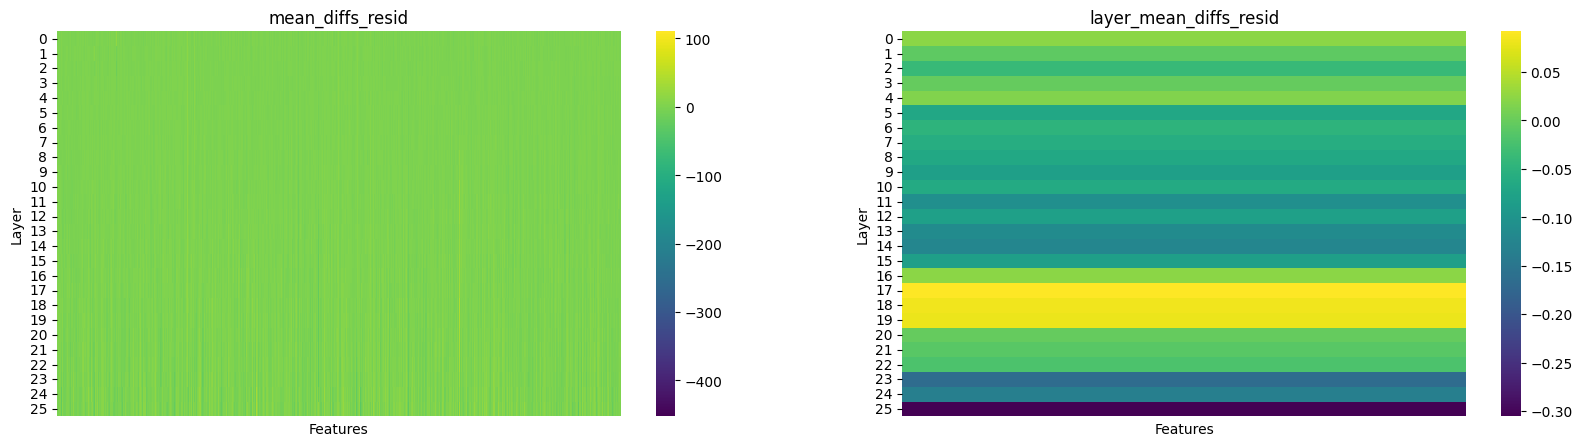

In [17]:
layer_mean_diffs_resid = torch.mean(mean_diffs_resid, dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
draw_heatmap(mean_diffs_resid, "mean_diffs_resid", axes[0])
draw_heatmap(layer_mean_diffs_resid, "layer_mean_diffs_resid", axes[1])
plt.show()